In [65]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy import signal
import sounddevice as sd
import soundfile as sf

In [8]:
def create_sin_waves(amplitude, frequency, duration, sampling_rate, phase):
    '''
    A function to create sin wave
    '''
 
    # create a time array 
    t = np.linspace(0, duration, int(sampling_rate * duration), False) 
 
    # generate the sine wave 
    waveform = amplitude * np.sin(2 * np.pi * frequency * t + phase)
    
    return waveform


### 1. Create a synthetic signal as a sum of sinusoids (1 point)

#### a) create sinusoids with chosen amplitudes and phases

In [10]:
length = 3  # seconds
sampling_rate = 8000  # Hz

sin0 = create_sin_waves(5, 100, length, sampling_rate, 0)
sin1 = create_sin_waves(6, 500, length, sampling_rate, 20)
sin2 = create_sin_waves(7, 1500, length, sampling_rate, 40)
sin3 = create_sin_waves(8, 2500, length, sampling_rate, 60)


#### b.1) Play sinusoids

In [17]:
sd.play(sin0, sampling_rate)
sd.wait()
sd.play(sin1, sampling_rate)
sd.wait()
sd.play(sin2, sampling_rate)
sd.wait()
sd.play(sin3, sampling_rate)

#### b.2) Plot sinusoids (only first 200 samples are displayed for better visualization)

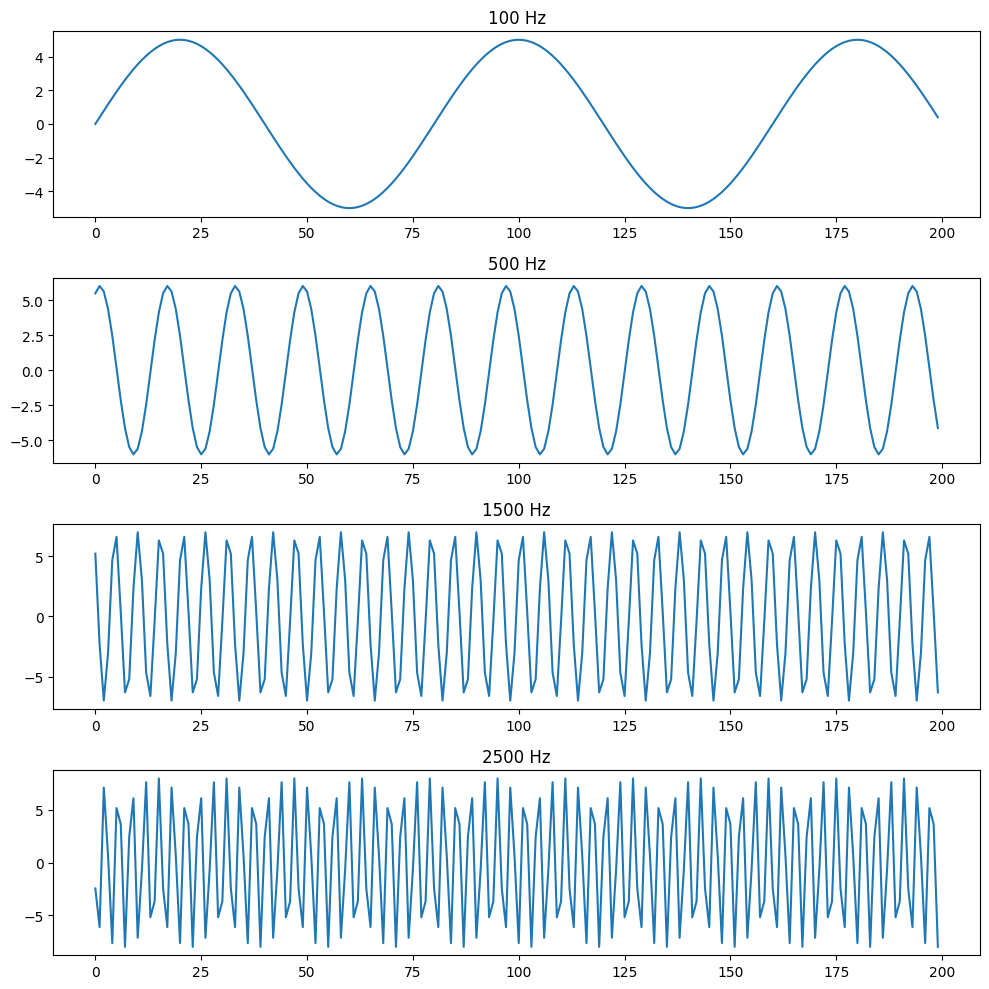

In [18]:
figure, axis = plt.subplots(4, 1, figsize=(10, 10))
axis[0].plot(sin0[:200])
axis[0].set_title('100 Hz')
axis[1].plot(sin1[:200])
axis[1].set_title('500 Hz')
axis[2].plot(sin2[:200])
axis[2].set_title('1500 Hz')
axis[3].plot(sin3[:200])
axis[3].set_title('2500 Hz')

plt.tight_layout()

plt.show()

#### c) Add them up to x(t). Plot and play x(t). Write the signal to a wav file.

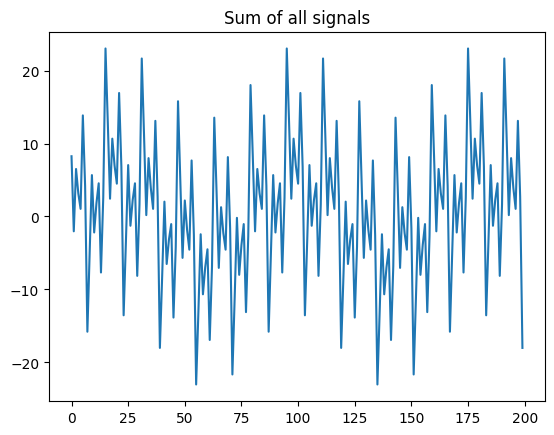

In [22]:
x_t = np.sum([sin0, sin1, sin2, sin3], axis=0)
plt.plot(x_t[:200])
plt.title('Sum of all signals')
plt.show()

# write signal as wav file
sf.write('sum_of_sine.wav', x_t, sampling_rate)


#### d) Apply DFT with nfft= 512

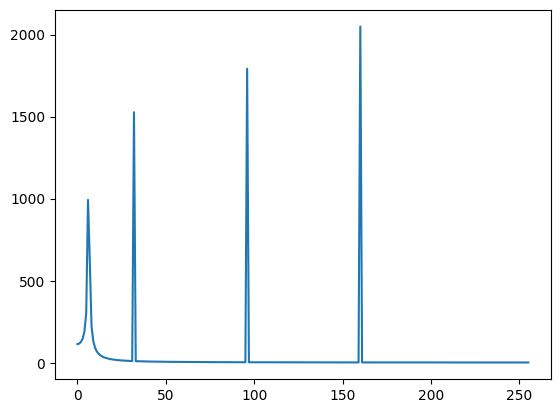

In [50]:
%matplotlib inline

fft_x_t_512 = fft(x_t, n=512)
plt.plot(np.abs(fft_x_t_512)[:512//2])
plt.show()

#### d.1) Apply DFT with nfft= 258

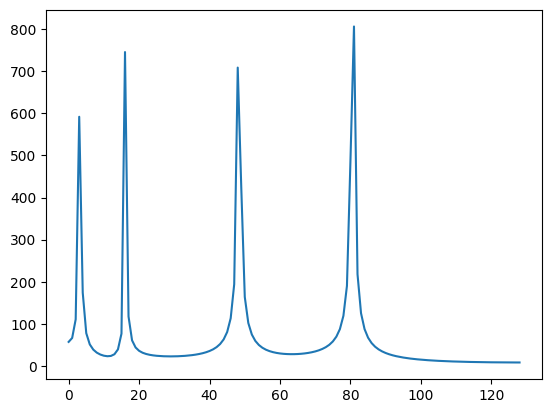

In [51]:
fft_x_t_258 = fft(x_t, n=258)
plt.plot(np.abs(fft_x_t_258)[:258//2])

#### d.2) Apply DFT with nfft= signal length

In [45]:
print(len(x_t))

24000


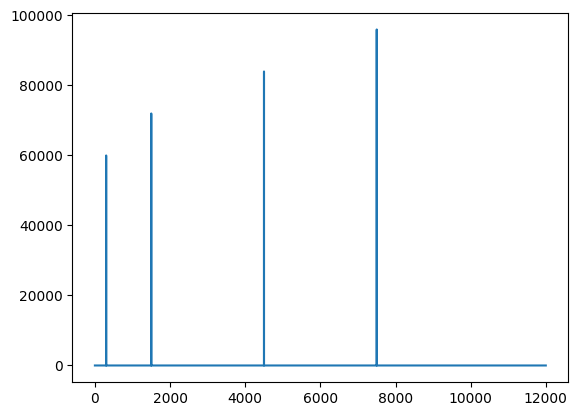

In [52]:
fft_x_t = fft(x_t, n=len(x_t))
plt.plot(np.abs(fft_x_t)[:len(x_t)//2])

#### e) Observe the components and relationship between nfft and frequency in Hz. Report your observation

In [83]:
import numpy as np
from scipy.signal import find_peaks

def extract_fft_peaks(fft_signal, height_threshold=0.1):
    """
    Extracts the top indices and amplitudes from an FFT signal.

    Parameters:
    - fft_signal: array-like, complex FFT result.
    - height_threshold: float, minimum amplitude for a peak to be considered.

    Returns:
    - tuple of (peak_indices, peak_amplitudes)
    """
    # Calculate the magnitude of the FFT
    magnitudes = np.abs(fft_signal)
    
    # Only consider the first half (positive frequencies)
    positive_magnitudes = magnitudes[:len(magnitudes) // 2]

    # Find peaks in the magnitudes
    peaks, _ = find_peaks(positive_magnitudes, height=height_threshold)
    
    # Extract peak indices and amplitudes
    peak_indices = peaks
    peak_amplitudes = positive_magnitudes[peaks]

    return peak_indices, peak_amplitudes

freqx, magx = extract_fft_peaks(fft_x_t, )

print("Spike Indices (len(x_t)//2):", freqx)
print("Spikes (len(x_t)//2):", magx)

freq5, mag5 = extract_fft_peaks(fft_x_t_512)

print("Spike Indices (512):", freq5)
print("Spikes (512):", mag5)

freq2, mag2 = extract_fft_peaks(fft_x_t_258)

print("Spike Indices (258):", freq2)
print("Spikes (258):", mag2)

Spike Indices (len(x_t)//2): [ 300 1500 4500 7500]
Spikes (len(x_t)//2): [60000. 72000. 84000. 96000.]
Spike Indices (512): [  6  32  96 160]
Spikes (512): [ 992.7323986  1527.08769308 1791.95126959 2049.46397602]
Spike Indices (258): [ 3 16 48 81]
Spikes (258): [591.89400561 745.62905228 708.71055566 806.40916545]


Spike Indices (len(x_t)//2): [ 300 1500 4500 7500]
Spikes (len(x_t)//2): [60000. 72000. 84000. 96000.]
Spike Indices (512): [  6  32  96 160]
Spikes (512): [ 992.7323986  1527.08769308 1791.95126959 2049.46397602]
Spike Indices (258): [ 3 16 48 81]
Spikes (258): [591.89400561 745.62905228 708.71055566 806.40916545]

We can see that nfft scales the result with the formula
(spike_index*fs)/nfft, whre fs = 8000.
Let's correct.

In [84]:
# Scale the frequency and magnitude results by nfft/fs
def scale_fft_results(freq, mag, nfft, fs=8000):
    scale_factor = fs / nfft
    scaled_freq = freq * scale_factor
    scaled_mag = mag * scale_factor
    return scaled_freq, scaled_mag

# Scale results for fft_x_t
scaled_freqx, scaled_magx = scale_fft_results(freqx, magx, len(x_t))
print("Scaled Spike Indices (len(x_t)//2):", scaled_freqx)
print("Scaled Spikes (len(x_t)//2):", scaled_magx)

# Scale results for fft_x_t_512
scaled_freq5, scaled_mag5 = scale_fft_results(freq5, mag5, 512)
print("Scaled Spike Indices (512):", scaled_freq5)
print("Scaled Spikes (512):", scaled_mag5)

# Scale results for fft_x_t_258
scaled_freq2, scaled_mag2 = scale_fft_results(freq2, mag2, 258)
print("Scaled Spike Indices (258):", scaled_freq2)
print("Scaled Spikes (258):", scaled_mag2)

Scaled Spike Indices (len(x_t)//2): [ 100.  500. 1500. 2500.]
Scaled Spikes (len(x_t)//2): [20000. 24000. 28000. 32000.]
Scaled Spike Indices (512): [  93.75  500.   1500.   2500.  ]
Scaled Spikes (512): [15511.4437281  23860.74520441 27999.2385874  32022.8746253 ]
Scaled Spike Indices (258): [  93.02325581  496.12403101 1488.37209302 2511.62790698]
Scaled Spikes (258): [18353.30249967 23120.28069075 21975.52110569 25004.93536286]


Result:

Scaled Spike Indices (len(x_t)//2): [ 100.  500. 1500. 2500.]
Scaled Spikes (len(x_t)//2): [20000. 24000. 28000. 32000.]
Scaled Spike Indices (512): [  93.75  500.   1500.   2500.  ]
Scaled Spikes (512): [15511.4437281  23860.74520441 27999.2385874  32022.8746253 ]
Scaled Spike Indices (258): [  93.02325581  496.12403101 1488.37209302 2511.62790698]
Scaled Spikes (258): [18353.30249967 23120.28069075 21975.52110569 25004.93536286]

We can see that the resolution of the lower nfft was not sufficient to gather
the correct signal information, but they are still somewhat close.

### 2. Read an audio and observe the spectrum. (1 point)

#### a) Read 'audio1.wav' 

In [102]:
horn, sample_rate = sf.read('audio1.wav')

#### a.1) Play

In [103]:
sd.play(horn, sample_rate)

#### a.2) Plot

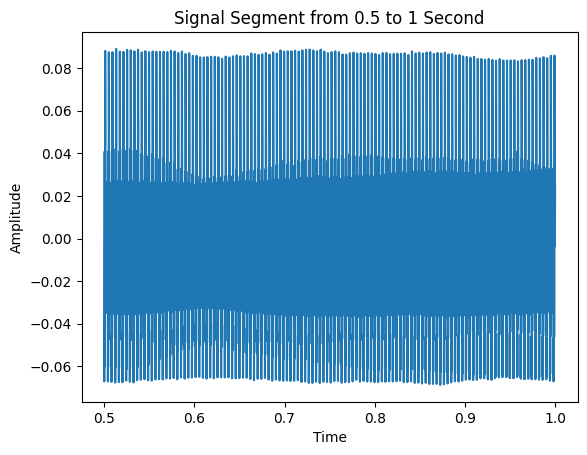

In [106]:
# Define the time range
start_time = 0.5  # seconds
end_time = 1.0  # seconds

# Calculate the indices
start_index = int(start_time * sample_rate)
end_index = int(end_time * sample_rate)

# Extract the segment
segment = horn[start_index:end_index]
time_axis = np.linspace(start_time, end_time, len(segment))

# Plot the segment
plt.plot(time_axis, segment)
plt.title('Signal Segment from 0.5 to 1 Second')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

#### a.3) Read 'audio2.wav' 

In [111]:
speech, sample_rate = sf.read('audio2.wav')

#### a.4) Play

In [112]:
sd.play(speech, sample_rate)

#### a.5) Plot

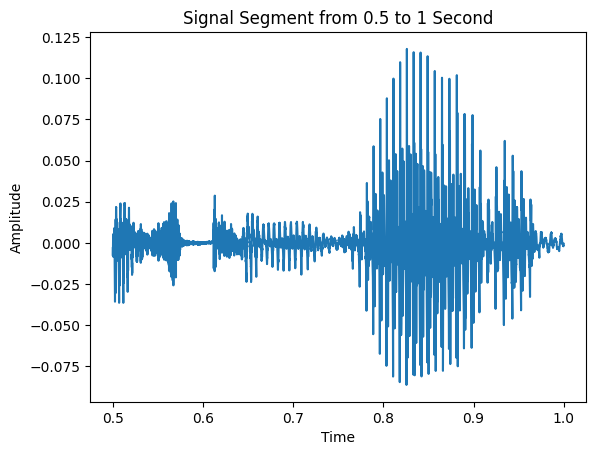

In [113]:
# Define the time range
start_time = 0.5  # seconds
end_time = 1.0  # seconds

# Calculate the indices
start_index = int(start_time * sample_rate)
end_index = int(end_time * sample_rate)

# Extract the segment
segment = speech[start_index:end_index]
time_axis = np.linspace(start_time, end_time, len(segment))

# Plot the segment
plt.plot(time_axis, segment)
plt.title('Signal Segment from 0.5 to 1 Second')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

#### c,d) Compute DFT in a loop for 'audio1.wav' 

In [143]:
def extract_audio_segments(signal, frame_length, sample_rate):
    audio_segments = []
    dft_segments = []

    # Read next 100 ms of the signal, apply DFT and repeat until end of file
    for i in range(0, len(signal), int(frame_length * sample_rate)):
        start_index = i
        end_index = i + int(frame_length * sample_rate)
        segment = signal[start_index:end_index]
        audio_segments.append(segment)
        
        fft_segment = fft(segment)
        dft_segments.append(fft_segment)
    
    return audio_segments, dft_segments

horn, sample_rate = sf.read('audio1.wav')

frame_length = 0.1  # seconds

horn_audios, horn_dft = extract_audio_segments(horn, frame_length, sample_rate)


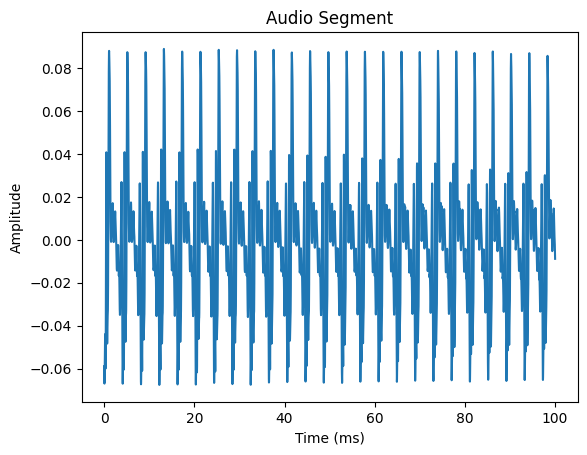

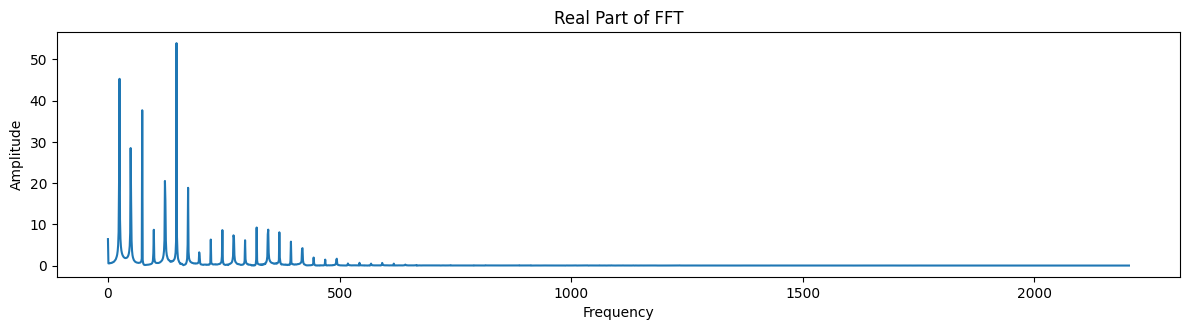

In [144]:
# Plot the audio segment
time_axis = np.linspace(0, len(horn_audios[5]) / sample_rate * 1000, len(horn_audios[5]))
plt.plot(time_axis, horn_audios[5])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Audio Segment')

# Plot the magnitude of the FFT (only the first half)
plt.figure(figsize=(12, 6))

# Plot the DFT mags
plt.subplot(2, 1, 1)
plt.plot(np.abs(horn_dft[5][:len(horn_dft[5])//2]))
plt.title('Real Part of FFT')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

#### c,d) Compute DFT in a loop for 'audio2.wav' 

In [151]:
speech, sample_rate = sf.read('audio2.wav')

frame_length = 0.1  # seconds

speech_audios, speech_dft = extract_audio_segments(speech, frame_length, sample_rate)

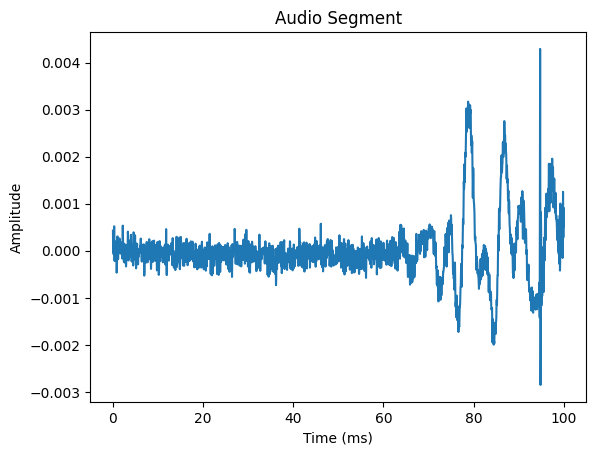

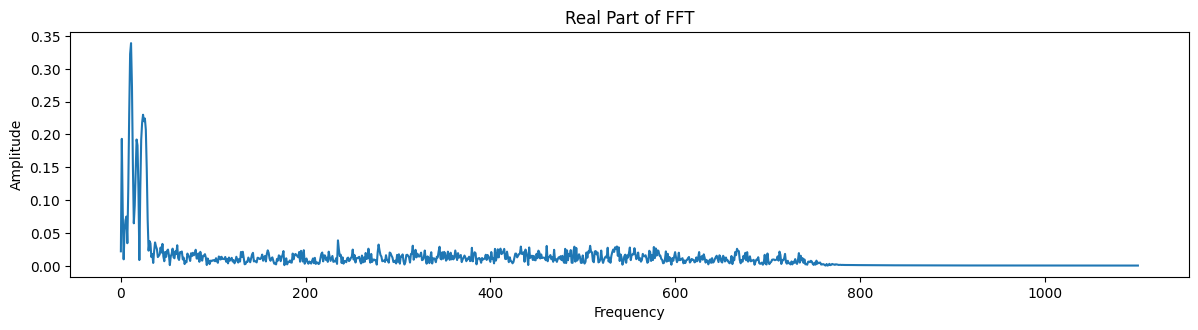

In [153]:
# Plot the audio segment
time_axis = np.linspace(0, len(speech_audios[0]) / sample_rate * 1000, len(speech_audios[0]))
plt.plot(time_axis, speech_audios[0])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Audio Segment')

# Plot the magnitude of the FFT (only the first half)
plt.figure(figsize=(12, 6))

# Plot the DFT mags
plt.subplot(2, 1, 1)
plt.plot(np.abs(speech_dft[0][:len(speech_dft[0])//2]))
plt.title('Real Part of FFT')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

#### e) How does the spectrum of these signals differ from that of sum of sinusoids? 

The spectrum does differ from the sum of sinusoids. There aren't as clear spikes as the sum of sinusoids and the spectrums are noisier. This is probably because the audio signals are much more complex.

### Bonus problem: